In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import random

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# ======================================================
# 1. CONFIG: SET YOUR PATHS + HOW MANY IMAGES TO USE
# ======================================================
# Root folder containing sharp/ and blurry/ subfolders
DATA_ROOT = "/content/drive/MyDrive/malaria_quantitation/quality"  # <-- CHANGE THIS

SHARP_DIR = os.path.join(DATA_ROOT, "sharp")
BLURRY_DIR = os.path.join(DATA_ROOT, "blurred")
TEST_DIR = os.path.join(DATA_ROOT, "test")

test_files = sorted(glob.glob(os.path.join(TEST_DIR, "*")))

# How many images from each class to use (None = use all)
N_IMAGES_PER_CLASS = 100   # set to None to use all available images

# ======================================================


In [3]:
# 2. LAPLACIAN FOCUS SCORE FUNCTION
# ======================================================
def laplacian_focus_score(img_path):
    """
    Compute Laplacian variance (focus measure) for one image.
    Higher = sharper, lower = blurrier.
    """
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Could not read image: {img_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    return lap.var()

# ======================================================


In [4]:
# 3. LOAD FILE PATHS AND OPTIONALLY SLICE TO FIRST N
# ======================================================
sharp_files = sorted(glob.glob(os.path.join(SHARP_DIR, "*")))
blurry_files = sorted(glob.glob(os.path.join(BLURRY_DIR, "*")))

if N_IMAGES_PER_CLASS is not None:
    sharp_files = sharp_files[:N_IMAGES_PER_CLASS]
    blurry_files = blurry_files[:N_IMAGES_PER_CLASS]

print(f"# sharp images used : {len(sharp_files)}")
print(f"# blurry images used: {len(blurry_files)}")

if len(sharp_files) == 0 or len(blurry_files) == 0:
    raise RuntimeError("No images found in sharp/ or blurry/ folders. Check DATA_ROOT and folder names.")

# ======================================================


# sharp images used : 100
# blurry images used: 100


In [5]:
# 4. COMPUTE LAPLACIAN SCORES + TRUE LABELS
# ======================================================
scores = []
labels = []   # 0 = sharp, 1 = blurry

for f in sharp_files:
    scores.append(laplacian_focus_score(f))
    labels.append(0)

for f in blurry_files:
    scores.append(laplacian_focus_score(f))
    labels.append(1)

scores = np.array(scores)
labels = np.array(labels)

print("\nExample Laplacian scores:")
print(f"  mean sharp  score : {scores[labels == 0].mean():.4f}")
print(f"  mean blurry score : {scores[labels == 1].mean():.4f}")

# ======================================================


Example Laplacian scores:
  mean sharp  score : 2.3893
  mean blurry score : 0.7236


In [6]:
# 5. THRESHOLD SWEEP: FIND BEST THRESHOLD
# ======================================================
# Convention:
#   score < threshold -> predict blurry (1)
#   score >= threshold -> predict sharp  (0)

def eval_threshold(th):
    y_pred = (scores < th).astype(int)  # 1 = blurry, 0 = sharp
    acc = accuracy_score(labels, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, y_pred, average="binary", pos_label=1, zero_division=0
    )
    return acc, precision, recall, f1, y_pred

best_f1 = -1.0
best_thresh = None
best_metrics = None
best_pred = None

ths = np.linspace(scores.min(), scores.max(), 50)

acc_list = []
prec_list = []
rec_list = []
f1_list = []

for th in ths:
    acc, prec, rec, f1, y_pred = eval_threshold(th)

    acc_list.append(acc)
    prec_list.append(prec)
    rec_list.append(rec)
    f1_list.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = th
        best_metrics = (acc, prec, rec, f1)
        best_pred = y_pred

# ======================================================


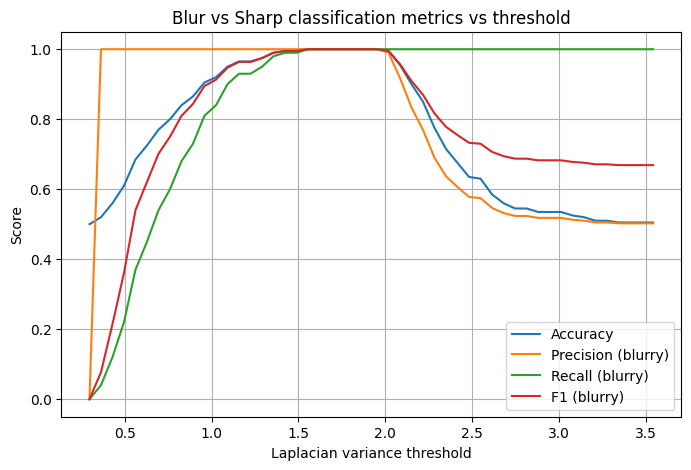

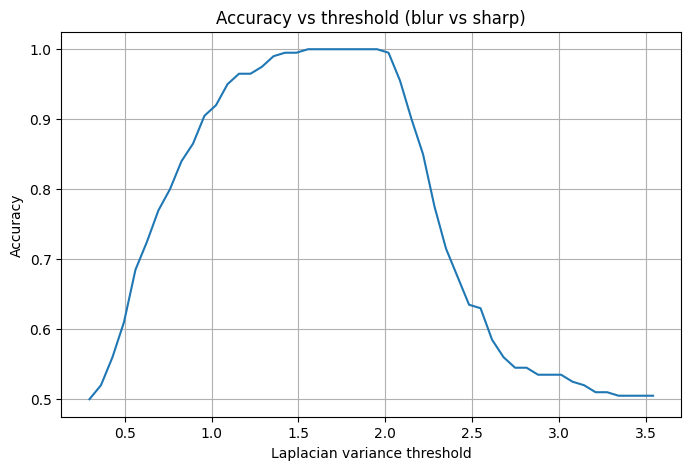

In [7]:
# 6. PLOTS: METRICS VS THRESHOLD
# ======================================================
plt.figure(figsize=(8, 5))
plt.plot(ths, acc_list, label="Accuracy")
plt.plot(ths, prec_list, label="Precision (blurry)")
plt.plot(ths, rec_list, label="Recall (blurry)")
plt.plot(ths, f1_list, label="F1 (blurry)")
plt.xlabel("Laplacian variance threshold")
plt.ylabel("Score")
plt.title("Blur vs Sharp classification metrics vs threshold")
plt.legend()
plt.grid(True)
plt.show()

# Optional: accuracy-only plot
plt.figure(figsize=(8, 5))
plt.plot(ths, acc_list)
plt.xlabel("Laplacian variance threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs threshold (blur vs sharp)")
plt.grid(True)
plt.show()

# ======================================================


In [8]:
# 7. REPORT FINAL METRICS AT BEST THRESHOLD
# ======================================================
acc, prec, rec, f1 = best_metrics
cm = confusion_matrix(labels, best_pred)

print("\n=== Laplacian Blur Classifier Results ===")
print(f"Best threshold on Laplacian variance: {best_thresh:.4f}")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f} (for class 'blurry')")
print(f"Recall   : {rec:.3f} (for class 'blurry')")
print(f"F1-score : {f1:.3f}")

print("\nConfusion matrix (rows=true, cols=pred):")
print("             pred_sharp   pred_blurry")
print(f"true_sharp      {cm[0,0]:4d}           {cm[0,1]:4d}")
print(f"true_blurry     {cm[1,0]:4d}           {cm[1,1]:4d}")

# ======================================================



=== Laplacian Blur Classifier Results ===
Best threshold on Laplacian variance: 1.5549
Accuracy : 1.000
Precision: 1.000 (for class 'blurry')
Recall   : 1.000 (for class 'blurry')
F1-score : 1.000

Confusion matrix (rows=true, cols=pred):
             pred_sharp   pred_blurry
true_sharp       100              0
true_blurry        0            100


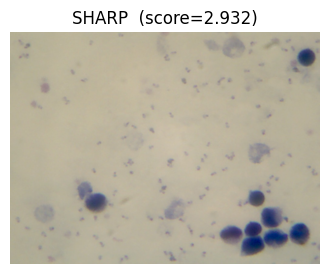

Image: /content/drive/MyDrive/malaria_quantitation/quality/test/plasmodium-2622.jpg
  Laplacian score: 2.932
  Predicted label: sharp


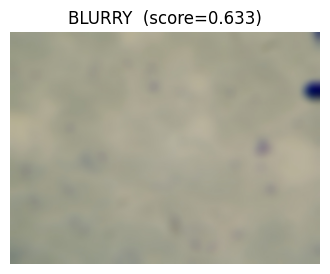

Image: /content/drive/MyDrive/malaria_quantitation/quality/test/blurred_plasmodium-2694.jpg
  Laplacian score: 0.633
  Predicted label: blurry


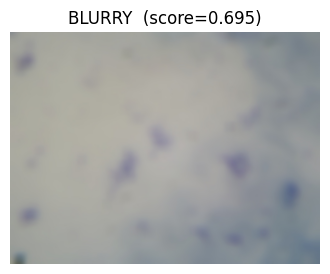

Image: /content/drive/MyDrive/malaria_quantitation/quality/test/blurred_plasmodium-2614.jpg
  Laplacian score: 0.695
  Predicted label: blurry


In [12]:
# 8. FUNCTION TO TEST AND DISPLAY ONE IMAGE
# ======================================================
def classify_and_show(img_path, threshold=None):
    """
    Show one image with its Laplacian score and predicted label.
    If threshold is None, uses best_thresh.
    """
    if threshold is None:
        threshold = best_thresh

    score = laplacian_focus_score(img_path)
    pred_label = "blurry" if score < threshold else "sharp"

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"{pred_label.upper()}  (score={score:.3f})")
    plt.axis("off")
    plt.show()

    print(f"Image: {img_path}")
    print(f"  Laplacian score: {score:.3f}")
    print(f"  Predicted label: {pred_label}")

# Example usage (uncomment if you want to test one or two):
# classify_and_show(sharp_files[0])
# classify_and_show(blurry_files[0])

n_to_show = 3  # how many test images you want to display

if len(test_files) == 0:
    print("No test images found in TEST_DIR.")
else:
    for f in random.sample(test_files, k=min(n_to_show, len(test_files))):
        classify_and_show(f)